# Import Necessary Files & Libraries

* There are a total of 7 files that need to be imported: 
  * labels-levela.csv
  * labels-levelb.csv
  * labels-levelc.csv
  * testset-levelc.tsv
  * testset-levelb.tsv
  * testset-levela.tsv
  * olid-training-v1.0.tsv

In [ ]:
#import the necessary libraries 
!pip install tweet-preprocessor
!pip install symspellpy
!pip install tqdm
from nltk.tokenize import TweetTokenizer
from symspellpy.symspellpy import SymSpell
from bs4 import BeautifulSoup
from nltk import word_tokenize, FreqDist
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk import ngrams
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS
import preprocessor as p
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
import tensorflow as tf 
import io
import re
import string
import nltk
import pkg_resources
nltk.download
nltk.download('wordnet')
nltk.download('stopwords')

     |████████████████████████████████| 2.6MB 5.3MB/s 
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#read the files into their respective dataframes 
labela_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levela.csv', header = None)
labelb_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levelb.csv', header = None)
labelc_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/labels-levelc.csv', header = None)
testa_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levela.tsv', sep = '\t')
testb_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levelb.tsv', sep = '\t')
testc_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/testset-levelc.tsv', sep = '\t')
train_df = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/olid-training-v1.0.tsv', sep = '\t')

In [ ]:
#Merge the label dataset with the test data set, so only Test data set needed

testa_df['subtask_a'] = labela_df[1]
testb_df['subtask_b'] = labelb_df[1]
testc_df['subtask_c'] = labelc_df[1]
testc_df.head()

,id,tweet,subtask_c
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...,OTH
1,60133,#NoPasaran: Unity demo to oppose the far-right...,GRP
2,83681,. . . What the fuck did he do this time?,IND
3,65507,@USER Do you get the feeling he is kissing @US...,OTH
4,34263,#StopKavanaugh he is liar like the rest of the...,IND


In [ ]:
#View the training data set
train_df.head()

,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


# Cleaning the Tweets

The training and test data are in 2 separate files, so a function has been written to to tidy the text up and return a column of cleaned tweets

* remove URLs, Hashtags, Mentions, Reserved Words (RT, FAV), Emojis
* Change text to lowercase 
* Handle Apostrophe (e.g. aren't -> are not)
* Remove punctuations
* Remove numbers 
* Segment the words (fix the spelling) 
* Lemmatization and Tokenization
* Remove Stop Words 

### Defining Cleaning Function and Others

In [ ]:
#list of contractions to remove later 
contractions = {
"ain't": "am not / are not",
"aren't": "are not / am not",
"can't": "cannot",
"can't've": "cannot have",
"'cause": "because",
"could've": "could have",
"couldn't": "could not",
"couldn't've": "could not have",
"didn't": "did not",
"doesn't": "does not",
"don't": "do not",
"hadn't": "had not",
"hadn't've": "had not have",
"hasn't": "has not",
"haven't": "have not",
"he'd": "he had / he would",
"he'd've": "he would have",
"he'll": "he shall / he will",
"he'll've": "he shall have / he will have",
"he's": "he has / he is",
"how'd": "how did",
"how'd'y": "how do you",
"how'll": "how will",
"how's": "how has / how is",
"i'd": "I had / I would",
"i'd've": "I would have",
"i'll": "I shall / I will",
"i'll've": "I shall have / I will have",
"i'm": "I am",
"i've": "I have",
"isn't": "is not",
"it'd": "it had / it would",
"it'd've": "it would have",
"it'll": "it shall / it will",
"it'll've": "it shall have / it will have",
"it's": "it has / it is",
"let's": "let us",
"ma'am": "madam",
"mayn't": "may not",
"might've": "might have",
"mightn't": "might not",
"mightn't've": "might not have",
"must've": "must have",
"mustn't": "must not",
"mustn't've": "must not have",
"needn't": "need not",
"needn't've": "need not have",
"o'clock": "of the clock",
"oughtn't": "ought not",
"oughtn't've": "ought not have",
"shan't": "shall not",
"sha'n't": "shall not",
"shan't've": "shall not have",
"she'd": "she had / she would",
"she'd've": "she would have",
"she'll": "she shall / she will",
"she'll've": "she shall have / she will have",
"she's": "she has / she is",
"should've": "should have",
"shouldn't": "should not",
"shouldn't've": "should not have",
"so've": "so have",
"so's": "so as / so is",
"that'd": "that would / that had",
"that'd've": "that would have",
"that's": "that has / that is",
"there'd": "there had / there would",
"there'd've": "there would have",
"there's": "there has / there is",
"they'd": "they had / they would",
"they'd've": "they would have",
"they'll": "they shall / they will",
"they'll've": "they shall have / they will have",
"they're": "they are",
"they've": "they have",
"to've": "to have",
"wasn't": "was not",
"we'd": "we had / we would",
"we'd've": "we would have",
"we'll": "we will",
"we'll've": "we will have",
"we're": "we are",
"we've": "we have",
"weren't": "were not",
"what'll": "what shall / what will",
"what'll've": "what shall have / what will have",
"what're": "what are",
"what's": "what has / what is",
"what've": "what have",
"when's": "when has / when is",
"when've": "when have",
"where'd": "where did",
"where's": "where has / where is",
"where've": "where have",
"who'll": "who shall / who will",
"who'll've": "who shall have / who will have",
"who's": "who has / who is",
"who've": "who have",
"why's": "why has / why is",
"why've": "why have",
"will've": "will have",
"won't": "will not",
"won't've": "will not have",
"would've": "would have",
"wouldn't": "would not",
"wouldn't've": "would not have",
"y'all": "you all",
"y'all'd": "you all would",
"y'all'd've": "you all would have",
"y'all're": "you all are",
"y'all've": "you all have",
"you'd": "you had / you would",
"you'd've": "you would have",
"you'll": "you shall / you will",
"you'll've": "you shall have / you will have",
"you're": "you are",
"you've": "you have"
}

In [ ]:
#Setting up SymSpell to segment words
sym_spell = SymSpell(max_dictionary_edit_distance=0, prefix_length=7)
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt")
# term_index is the column of the term and count_index is the column of the term frequency
sym_spell.load_dictionary(dictionary_path, term_index=0, count_index=1)


True

In [ ]:
#Setting up Lematizer, Tokenizer and Stopwords 
lemmatizer = nltk.stem.WordNetLemmatizer()
w_tokenizer = TweetTokenizer()
stop_words = set(stopwords.words('english'))

In [ ]:
def cleaner(row, contractions):
  #remove URLs, Hashtags, Mentions, Reserved Words (RT, FAV), Emojis
  row = p.clean(row)
  #lower the text 
  row = row.lower()
  #Apostrophe Handling
  for word in row.split():
    if word in contractions: 
      row = row.replace(word, contractions[word.lower()])
  #remove punctuations
  row  = "".join([char for char in row if char not in string.punctuation])
  row = re.sub('[0-9]+', '', row, flags=re.MULTILINE)
  #remove numbers 
  row = re.sub(r'\d+', '', row, flags=re.MULTILINE)
  #Segment the words 
  try:
    row = (sym_spell.word_segmentation(row)).corrected_string
  except: 
    pass
  #Lemmatization and Tokenization
  row = [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((row))]
  #Stopwords 
  row = [word for word in row if word not in stop_words]
  return row

### Applying the Cleaner

In [ ]:
#Apply the cleaner on all the datasets and use tqdm to monitor progress 
tqdm.pandas()

testc_df['clean_tweet'] = testc_df['tweet'].progress_apply(lambda x: cleaner(x, contractions))
testb_df['clean_tweet'] = testb_df['tweet'].progress_apply(lambda x: cleaner(x, contractions))
testa_df['clean_tweet'] = testa_df['tweet'].progress_apply(lambda x: cleaner(x, contractions))
train_df['clean_tweet'] = train_df['tweet'].progress_apply(lambda x: cleaner(x, contractions))

100%|██████████| 13240/13240 [02:25<00:00, 90.71it/s]


In [ ]:
train_df.tail()

,id,tweet,subtask_a,subtask_b,subtask_c,clean_tweet
13235,95338,@USER Sometimes I get strong vibes from people...,OFF,TIN,IND,"[sometimes, get, strong, vibe, people, man, vi..."
13236,67210,Benidorm ✅ Creamfields ✅ Maga ✅ Not too sh...,NOT,NaN,NaN,"[beni, dorm, cream, field, mag, shabby, summer]"
13237,82921,@USER And why report this garbage. We don't g...,OFF,TIN,OTH,"[report, garbage, give, crap]"
13238,27429,@USER Pussy,OFF,UNT,NaN,[pussy]
13239,46552,#Spanishrevenge vs. #justice #HumanRights and ...,NOT,NaN,NaN,"[v, url]"


In [ ]:
#Convert the Dataframes to CSV and download them
# testa_df.to_csv('clean_testa.csv')
# testb_df.to_csv('clean_testb.csv')
# testc_df.to_csv('clean_testc.csv')

In [ ]:
#Drop the rows which do not have values for b and c
# train_df_a = train_df.dropna(subset=['subtask_a'])
# train_df_a = train_df_b.drop(columns = ['subtask_b', 'subtask_c'])
# train_df_b = train_df.dropna(subset=['subtask_b'])
# train_df_b = train_df_b.drop(columns = ['subtask_a', 'subtask_c'])
# train_df_c = train_df.dropna(subset=['subtask_c'])
# train_df_c = train_df_c.drop(columns = ['subtask_a', 'subtask_b'])
# train_df_b.to_csv('clean_training_b.csv')
# train_df_c.to_csv('clean_training_c.csv')
# train_df_a.to_csv('clean_training_a.csv')

### Extra Cleaner with removal of custom words

In [ ]:
#Removes specially chosen stop words
def cleaner(row, contractions, blacklist, whitelist):
  '''
  Blacklist: Words that are not in stop words but we will be removing 
  Whitelist: Words that are in the stop words but we will be keeping
  '''
  #remove URLs, Hashtags, Mentions, Reserved Words (RT, FAV), Emojis
  row = p.clean(row)
  #lower the text 
  row = row.lower()
  #Apostrophe Handling
  for word in row.split():
    if word in contractions: 
      row = row.replace(word, contractions[word.lower()])
  #remove punctuations
  row  = "".join([char for char in row if char not in string.punctuation])
  row = re.sub('[0-9]+', '', row, flags=re.MULTILINE)
  #remove numbers 
  row = re.sub(r'\d+', '', row, flags=re.MULTILINE)
  #Segment the words 
  try:
    row = (sym_spell.word_segmentation(row)).corrected_string
  except: 
    pass
  #Lemmatization and Tokenization
  row = [(lemmatizer.lemmatize(w)) for w in w_tokenizer.tokenize((row))]
  #Stopwords 
  all_stopwords = stopwords.words('english')
  all_stopwords.extend(blacklist)
  all_stopwords = set(all_stopwords)- set(whitelist)
  row = [word for word in row if word not in all_stopwords]
  return row

In [ ]:
#List of stopwords that want to remove in addition to the ones in stopwords corpus
badboy_list = ['url', 'ha']
goodboy_list = ['i', 'he', 'she', 'it', 'him', 'her', 'we', 'you', 'they', 'us', 'them' ]
#Apply modified clean tweet to the training data
train_df['extra_clean_tweet'] = train_df['tweet'].progress_apply(lambda x: cleaner(x, contractions, badboy_list, goodboy_list))


100%|██████████| 13240/13240 [02:42<00:00, 81.30it/s]


In [ ]:
#Convert list to string
train_df['extra_clean_tweet'] = train_df['extra_clean_tweet'].apply(lambda x: ' '.join([str(elem) for elem in x]))
train_df.head()

,id,tweet,subtask_a,subtask_b,subtask_c,clean_tweet,extra_clean_tweet
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,"[ask, native, american, take]",she ask native american take
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,"[go, home, drunk, url]",go home you drunk
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,"[amazon, investigating, chinese, employee, sel...",amazon investigating chinese employee selling ...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,"[someone, vet, ken, piece, shit, volcano]",someone vet ken piece shit volcano
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,"[obama, wanted, liberal, amp, illegals, move, ...",obama wanted liberal amp illegals move red state


# Visualisation  

In [ ]:
train_df.groupby(['subtask_b']).count()

,id,tweet,subtask_a,subtask_c,clean_tweet,extra_clean_tweet
subtask_b,,,,,,
TIN,3876,3876,3876,3876,3876,3876
UNT,524,524,524,0,524,524


## Bar Chart

### Subtask A

('USER', 'She', 'should', 'ask', 'a', 'few', 'native', 'Americans', 'what', 'their', 'take', 'on', 'this', 'is', 'USER', 'USER', 'Go', 'home', 'youre', 'drunk', 'USER', 'MAGA', 'Trump2020', '👊🇺🇸👊', 'URL', 'USER', 'Someone', 'shouldveTaken', 'this', 'piece', 'of', 'shit', 'to', 'a', 'volcano', '😂', 'USER', 'Liberals', 'are', 'all', 'Kookoo', 'USER', 'USER', 'Oh', 'noes', 'Tough', 'shit', 'USER', 'was', 'literally', 'just', 'talking', 'about', 'this', 'lol', 'all', 'mass', 'shootings', 'like', 'that', 'have', 'been', 'set', 'ups', 'its', 'propaganda', 'used', 'to', 'divide', 'us', 'on', 'major', 'issues', 'like', 'gun', 'control', 'and', 'terrorism', 'USER', 'Canada', 'doesnt', 'need', 'another', 'CUCK', 'We', 'already', 'have', 'enough', 'LooneyLeft', 'Liberals', 'fking', 'up', 'our', 'great', 'country', 'Qproofs', 'TrudeauMustGo', 'USER', 'you', 'are', 'a', 'lying', 'corrupt', 'traitor', 'Nobody', 'wants', 'to', 'hear', 'anymore', 'of', 'your', 'lies', 'DeepStateCorruption', 'URL', 'US

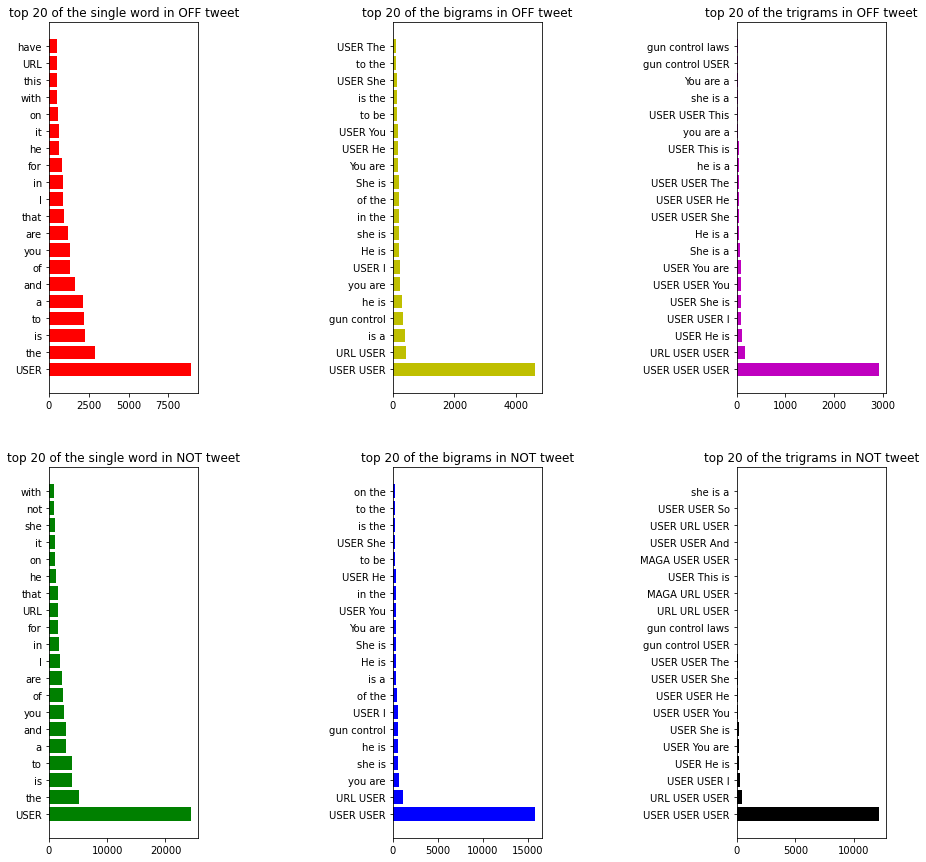

In [ ]:
labels = ['OFF', 'NOT']
tweet = train_df['tweet']
stop = stopwords.words('english')
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): return re_tok.sub('', s).split() 

# def group(off_text,notoff_text,stopwords):
#     off_text = off_text.str.lower()
#     off_text = off_text.str.replace('user','')
#     off_text = off_text.str.replace('url','')
#     off_words = off_text.apply(tokenize)
#     off = [j for i in off_words for j in i]
#     off_filtered = [w for w in off if w not in stop]

#     notoff_text = notoff_text.str.lower()
#     notoff_text = notoff_text.str.replace('user','')
#     notoff_text = notoff_text.str.replace('url','')
#     notoff_words = notoff_text.apply(tokenize)
#     notoff = [j for i in notoff_words for j in i]
#     notoff_filtered = [w for w in notoff if w not in stop]

#     return off_filtered, notoff_filtered

#Uncomment if want to use the group function to filter
#off_filtered, notoff_filtered = group(tweet[train_df['subtask_a']== 'OFF'],tweet[train_df['subtask_a']== 'NOT'],stopwords)
off_filtered = tuple(sum((tweet)[train_df['subtask_a']=='OFF'].map(tokenize), []))
notoff_filtered = tuple(sum((tweet)[train_df['subtask_a'] == 'NOT'].map(tokenize), []))
print(off_filtered)
bigram_off=list(ngrams(off_filtered,2))
bigram_notoff=list(ngrams(notoff_filtered,2))

trigram_off = list(ngrams(off_filtered,3))
trigram_notoff = list(ngrams(notoff_filtered,3))

def top_20(text,ngram=1):
    freq = FreqDist(text)
    most_freq = freq.most_common(20)
    if ngram==1:
        words = [w[0] for w in most_freq]
    else:
        words = [' '.join(w[0]) for w in most_freq]
    num = [n[1] for n in most_freq]
    return(words,num)

fig, ax = plt.subplots(2, 3, figsize=(15,15))
plt.subplots_adjust(wspace = 1.3)

ax[0, 0].barh(top_20(off_filtered)[0],top_20(off_filtered)[1], color = 'r') 
ax[0, 0].set_title("top 20 of the single word in %s tweet" % labels[0])

ax[1, 0].barh(top_20(notoff_filtered)[0],top_20(notoff_filtered)[1], color = 'g') 
ax[1, 0].set_title("top 20 of the single word in %s tweet" % labels[1])

ax[0, 1].barh(top_20(bigram_off,2)[0],top_20(bigram_off,2)[1], color = 'y') 
ax[0, 1].set_title("top 20 of the bigrams in %s tweet" % labels[0])

ax[1, 1].barh(top_20(bigram_notoff,2)[0],top_20(bigram_notoff,2)[1], color = 'b') 
ax[1, 1].set_title("top 20 of the bigrams in %s tweet" % labels[1])

ax[0, 2].barh(top_20(trigram_off,3)[0],top_20(trigram_off,3)[1], color = 'm') 
ax[0, 2].set_title("top 20 of the trigrams in %s tweet" % labels[0])

ax[1, 2].barh(top_20(trigram_notoff,3)[0],top_20(trigram_notoff,3)[1], color = 'k') 
ax[1, 2].set_title("top 20 of the trigrams in %s tweet" % labels[1])
plt.show()

### Subtask B

('USER', 'USER', 'Go', 'home', 'youre', 'drunk', 'USER', 'MAGA', 'Trump2020', '👊🇺🇸👊', 'URL', 'USER', 'Liberals', 'are', 'all', 'Kookoo', 'USER', 'was', 'literally', 'just', 'talking', 'about', 'this', 'lol', 'all', 'mass', 'shootings', 'like', 'that', 'have', 'been', 'set', 'ups', 'its', 'propaganda', 'used', 'to', 'divide', 'us', 'on', 'major', 'issues', 'like', 'gun', 'control', 'and', 'terrorism', 'USER', 'Canada', 'doesnt', 'need', 'another', 'CUCK', 'We', 'already', 'have', 'enough', 'LooneyLeft', 'Liberals', 'fking', 'up', 'our', 'great', 'country', 'Qproofs', 'TrudeauMustGo', 'USER', 'you', 'are', 'a', 'lying', 'corrupt', 'traitor', 'Nobody', 'wants', 'to', 'hear', 'anymore', 'of', 'your', 'lies', 'DeepStateCorruption', 'URL', 'USER', 'USER', 'USER', 'gun', 'control', 'That', 'is', 'all', 'these', 'kids', 'are', 'asking', 'for', 'USER', 'USER', 'USER', 'USER', 'LOL', 'Throwing', 'the', 'BULLSHIT', 'Flag', 'on', 'such', 'nonsense', 'PutUpOrShutUp', 'Kavanaugh', 'MAGA', 'CallTheVo

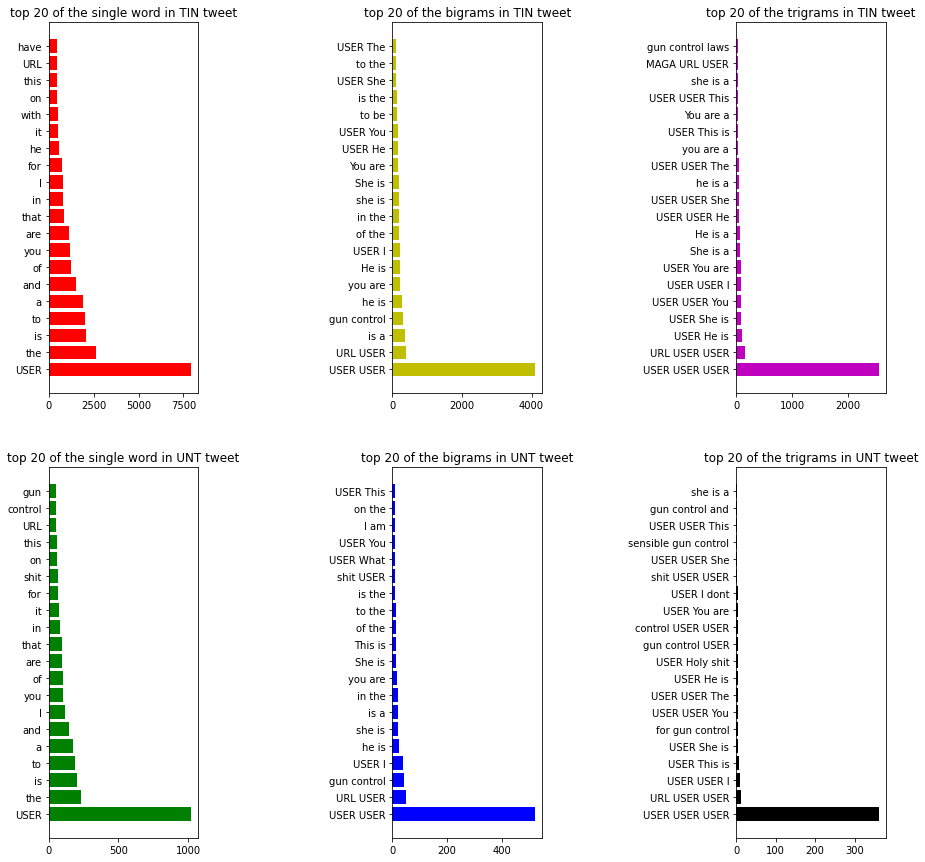

In [ ]:
labels = ['TIN', 'UNT']
tweet = train_df['tweet']
stop = stopwords.words('english')
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): return re_tok.sub('', s).split() 

# def group(off_text,notoff_text,stopwords):
#     off_text = off_text.str.lower()
#     off_text = off_text.str.replace('user','')
#     off_text = off_text.str.replace('url','')
#     off_words = off_text.apply(tokenize)
#     off = [j for i in off_words for j in i]
#     off_filtered = [w for w in off if w not in stop]

#     notoff_text = notoff_text.str.lower()
#     notoff_text = notoff_text.str.replace('user','')
#     notoff_text = notoff_text.str.replace('url','')
#     notoff_words = notoff_text.apply(tokenize)
#     notoff = [j for i in notoff_words for j in i]
#     notoff_filtered = [w for w in notoff if w not in stop]

#     return off_filtered, notoff_filtered

#Uncomment if want to use the group function to filter
#off_filtered, notoff_filtered = group(tweet[train_df['subtask_a']== 'OFF'],tweet[train_df['subtask_a']== 'NOT'],stopwords)
off_filtered = tuple(sum((tweet)[train_df['subtask_b']=='TIN'].map(tokenize), []))
notoff_filtered = tuple(sum((tweet)[train_df['subtask_b'] == 'UNT'].map(tokenize), []))
print(off_filtered)
bigram_off=list(ngrams(off_filtered,2))
bigram_notoff=list(ngrams(notoff_filtered,2))

trigram_off = list(ngrams(off_filtered,3))
trigram_notoff = list(ngrams(notoff_filtered,3))

def top_20(text,ngram=1):
    freq = FreqDist(text)
    most_freq = freq.most_common(20)
    if ngram==1:
        words = [w[0] for w in most_freq]
    else:
        words = [' '.join(w[0]) for w in most_freq]
    num = [n[1] for n in most_freq]
    return(words,num)

fig, ax = plt.subplots(2, 3, figsize=(15,15))
plt.subplots_adjust(wspace = 1.3)

ax[0, 0].barh(top_20(off_filtered)[0],top_20(off_filtered)[1], color = 'r') 
ax[0, 0].set_title("top 20 of the single word in %s tweet" % labels[0])

ax[1, 0].barh(top_20(notoff_filtered)[0],top_20(notoff_filtered)[1], color = 'g') 
ax[1, 0].set_title("top 20 of the single word in %s tweet" % labels[1])

ax[0, 1].barh(top_20(bigram_off,2)[0],top_20(bigram_off,2)[1], color = 'y') 
ax[0, 1].set_title("top 20 of the bigrams in %s tweet" % labels[0])

ax[1, 1].barh(top_20(bigram_notoff,2)[0],top_20(bigram_notoff,2)[1], color = 'b') 
ax[1, 1].set_title("top 20 of the bigrams in %s tweet" % labels[1])

ax[0, 2].barh(top_20(trigram_off,3)[0],top_20(trigram_off,3)[1], color = 'm') 
ax[0, 2].set_title("top 20 of the trigrams in %s tweet" % labels[0])

ax[1, 2].barh(top_20(trigram_notoff,3)[0],top_20(trigram_notoff,3)[1], color = 'k') 
ax[1, 2].set_title("top 20 of the trigrams in %s tweet" % labels[1])
plt.show()

### Subtask C

Tweets that have not been cleaned

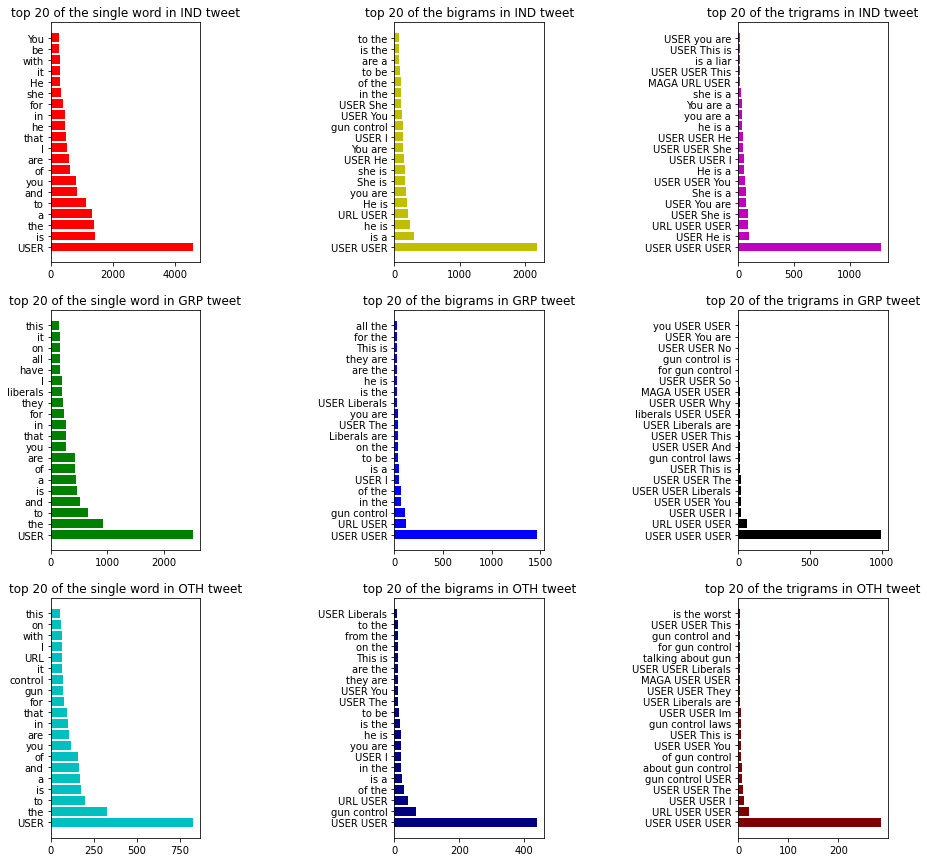

In [ ]:
labels = ['IND', 'GRP', 'OTH']
tweet = train_df['tweet']
stop = stopwords.words('english')
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): return re_tok.sub('', s).split() 

# def group(off_text,notoff_text,stopwords):
#     off_text = off_text.str.lower()
#     off_text = off_text.str.replace('user','')
#     off_text = off_text.str.replace('url','')
#     off_words = off_text.apply(tokenize)
#     off = [j for i in off_words for j in i]
#     off_filtered = [w for w in off if w not in stop]

#     notoff_text = notoff_text.str.lower()
#     notoff_text = notoff_text.str.replace('user','')
#     notoff_text = notoff_text.str.replace('url','')
#     notoff_words = notoff_text.apply(tokenize)
#     notoff = [j for i in notoff_words for j in i]
#     notoff_filtered = [w for w in notoff if w not in stop]

#     return off_filtered, notoff_filtered

#Uncomment if want to use the group function to filter
#off_filtered, notoff_filtered = group(tweet[train_df['subtask_a']== 'OFF'],tweet[train_df['subtask_a']== 'NOT'],stopwords)
ind_filtered = tuple(sum((tweet)[train_df['subtask_c']=='IND'].map(tokenize), []))
grp_filtered = tuple(sum((tweet)[train_df['subtask_c'] == 'GRP'].map(tokenize), []))
oth_filtered = tuple(sum((tweet)[train_df['subtask_c'] == 'OTH'].map(tokenize), []))
#print(oth_filtered)
bigram_ind=list(ngrams(ind_filtered,2))
bigram_grp=list(ngrams(grp_filtered,2))
bigram_oth=list(ngrams(oth_filtered,2))

trigram_ind = list(ngrams(ind_filtered,3))
trigram_grp = list(ngrams(grp_filtered,3))
trigram_oth = list(ngrams(oth_filtered,3))

def top_20(text,ngram=1):
    freq = FreqDist(text)
    most_freq = freq.most_common(20)
    if ngram==1:
        words = [w[0] for w in most_freq]
    else:
        words = [' '.join(w[0]) for w in most_freq]
    num = [n[1] for n in most_freq]
    return(words,num)

fig, ax = plt.subplots(3, 3, figsize=(15,15))
plt.subplots_adjust(wspace = 1.3)

ax[0, 0].barh(top_20(ind_filtered)[0],top_20(ind_filtered)[1], color = 'r') 
ax[0, 0].set_title("top 20 of the single word in %s tweet" % labels[0])

ax[1, 0].barh(top_20(grp_filtered)[0],top_20(grp_filtered)[1], color = 'g') 
ax[1, 0].set_title("top 20 of the single word in %s tweet" % labels[1])

ax[2, 0].barh(top_20(oth_filtered)[0],top_20(oth_filtered)[1], color = 'c') 
ax[2, 0].set_title("top 20 of the single word in %s tweet" % labels[2])

ax[0, 1].barh(top_20(bigram_ind,2)[0],top_20(bigram_ind,2)[1], color = 'y') 
ax[0, 1].set_title("top 20 of the bigrams in %s tweet" % labels[0])

ax[1, 1].barh(top_20(bigram_grp,2)[0],top_20(bigram_grp,2)[1], color = 'b') 
ax[1, 1].set_title("top 20 of the bigrams in %s tweet" % labels[1])

ax[2, 1].barh(top_20(bigram_oth,2)[0],top_20(bigram_oth,2)[1], color = 'navy') 
ax[2, 1].set_title("top 20 of the bigrams in %s tweet" % labels[2])

ax[0, 2].barh(top_20(trigram_ind,3)[0],top_20(trigram_ind,3)[1], color = 'm') 
ax[0, 2].set_title("top 20 of the trigrams in %s tweet" % labels[0])

ax[1, 2].barh(top_20(trigram_grp,3)[0],top_20(trigram_grp,3)[1], color = 'k') 
ax[1, 2].set_title("top 20 of the trigrams in %s tweet" % labels[1])

ax[2, 2].barh(top_20(trigram_oth,3)[0],top_20(trigram_oth,3)[1], color = 'maroon') 
ax[2, 2].set_title("top 20 of the trigrams in %s tweet" % labels[2])
plt.show()

### Subtask C

Tweets that have been cleaned

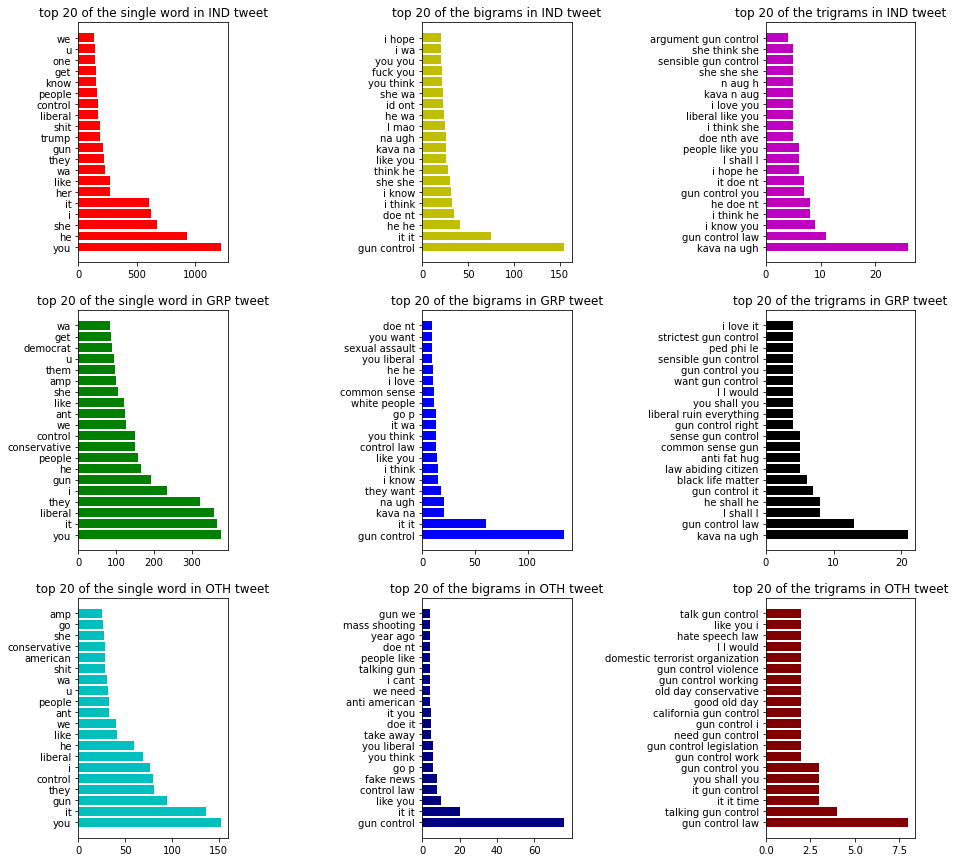

In [ ]:
labels = ['IND', 'GRP', 'OTH']
tweet = train_df['extra_clean_tweet']
stop = stopwords.words('english')
re_tok = re.compile(f'([{string.punctuation}“”¨«»®´·º½¾¿¡§£₤‘’])')

def tokenize(s): return re_tok.sub('', s).split() 

# def group(off_text,notoff_text,stopwords):
#     off_text = off_text.str.lower()
#     off_text = off_text.str.replace('user','')
#     off_text = off_text.str.replace('url','')
#     off_words = off_text.apply(tokenize)
#     off = [j for i in off_words for j in i]
#     off_filtered = [w for w in off if w not in stop]

#     notoff_text = notoff_text.str.lower()
#     notoff_text = notoff_text.str.replace('user','')
#     notoff_text = notoff_text.str.replace('url','')
#     notoff_words = notoff_text.apply(tokenize)
#     notoff = [j for i in notoff_words for j in i]
#     notoff_filtered = [w for w in notoff if w not in stop]

#     return off_filtered, notoff_filtered

#Uncomment if want to use the group function to filter
#off_filtered, notoff_filtered = group(tweet[train_df['subtask_a']== 'OFF'],tweet[train_df['subtask_a']== 'NOT'],stopwords)
ind_filtered = tuple(sum((tweet)[train_df['subtask_c']=='IND'].map(tokenize), []))
grp_filtered = tuple(sum((tweet)[train_df['subtask_c'] == 'GRP'].map(tokenize), []))
oth_filtered = tuple(sum((tweet)[train_df['subtask_c'] == 'OTH'].map(tokenize), []))
#print(oth_filtered)
bigram_ind=list(ngrams(ind_filtered,2))
bigram_grp=list(ngrams(grp_filtered,2))
bigram_oth=list(ngrams(oth_filtered,2))

trigram_ind = list(ngrams(ind_filtered,3))
trigram_grp = list(ngrams(grp_filtered,3))
trigram_oth = list(ngrams(oth_filtered,3))

def top_20(text,ngram=1):
    freq = FreqDist(text)
    most_freq = freq.most_common(20)
    if ngram==1:
        words = [w[0] for w in most_freq]
    else:
        words = [' '.join(w[0]) for w in most_freq]
    num = [n[1] for n in most_freq]
    return(words,num)

fig, ax = plt.subplots(3, 3, figsize=(15,15))
plt.subplots_adjust(wspace = 1.3)

ax[0, 0].barh(top_20(ind_filtered)[0],top_20(ind_filtered)[1], color = 'r') 
ax[0, 0].set_title("top 20 of the single word in %s tweet" % labels[0])

ax[1, 0].barh(top_20(grp_filtered)[0],top_20(grp_filtered)[1], color = 'g') 
ax[1, 0].set_title("top 20 of the single word in %s tweet" % labels[1])

ax[2, 0].barh(top_20(oth_filtered)[0],top_20(oth_filtered)[1], color = 'c') 
ax[2, 0].set_title("top 20 of the single word in %s tweet" % labels[2])

ax[0, 1].barh(top_20(bigram_ind,2)[0],top_20(bigram_ind,2)[1], color = 'y') 
ax[0, 1].set_title("top 20 of the bigrams in %s tweet" % labels[0])

ax[1, 1].barh(top_20(bigram_grp,2)[0],top_20(bigram_grp,2)[1], color = 'b') 
ax[1, 1].set_title("top 20 of the bigrams in %s tweet" % labels[1])

ax[2, 1].barh(top_20(bigram_oth,2)[0],top_20(bigram_oth,2)[1], color = 'navy') 
ax[2, 1].set_title("top 20 of the bigrams in %s tweet" % labels[2])

ax[0, 2].barh(top_20(trigram_ind,3)[0],top_20(trigram_ind,3)[1], color = 'm') 
ax[0, 2].set_title("top 20 of the trigrams in %s tweet" % labels[0])

ax[1, 2].barh(top_20(trigram_grp,3)[0],top_20(trigram_grp,3)[1], color = 'k') 
ax[1, 2].set_title("top 20 of the trigrams in %s tweet" % labels[1])

ax[2, 2].barh(top_20(trigram_oth,3)[0],top_20(trigram_oth,3)[1], color = 'maroon') 
ax[2, 2].set_title("top 20 of the trigrams in %s tweet" % labels[2])
plt.show()

## Word Cloud

### For all training data without stop words

In [ ]:
stopwords2 = set(STOPWORDS)
wordcloud2 = WordCloud(width = 800, height = 800, 
            background_color ='white',  
            stopwords = stopwords2, 
            min_font_size = 10).generate(' '.join(train_df['tweet']))

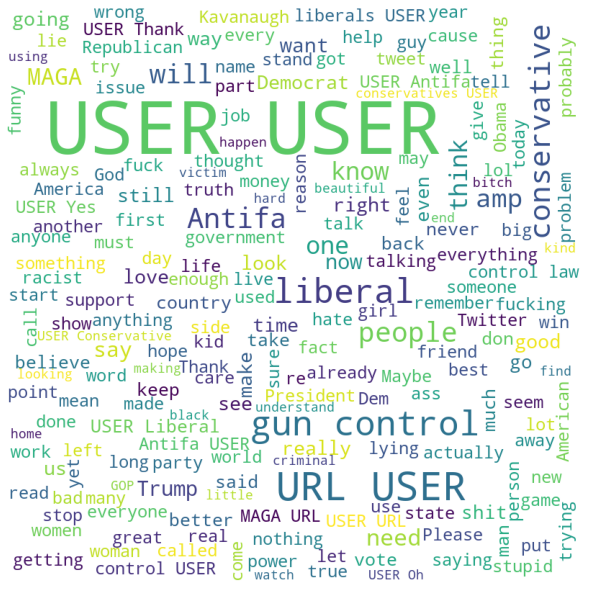

In [ ]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud2) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

### For the completely cleaned data

In [ ]:
#Convert list to string
train_df['clean_tweet_str'] = train_df['clean_tweet'].apply(lambda x: ' '.join([str(elem) for elem in x]))

In [ ]:
wordcloud3 = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            min_font_size = 10).generate(' '.join(train_df['clean_tweet_str']))

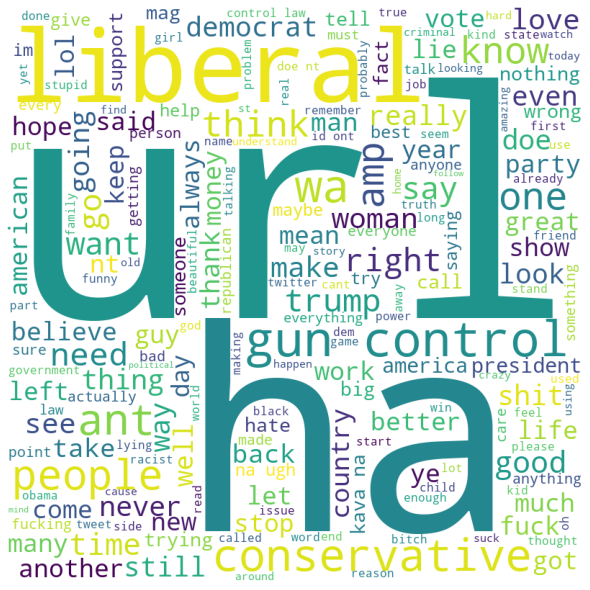

In [ ]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud3) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show() 

### Removal of additional stop words

What can be observed is that certain words such as user need to be removed as they are not adding much value, such as user, URL, user

In [ ]:
wordcloud4 = WordCloud(width = 800, height = 800, 
            background_color ='white', 
            min_font_size = 10).generate(' '.join(train_df['extra_clean_tweet']))

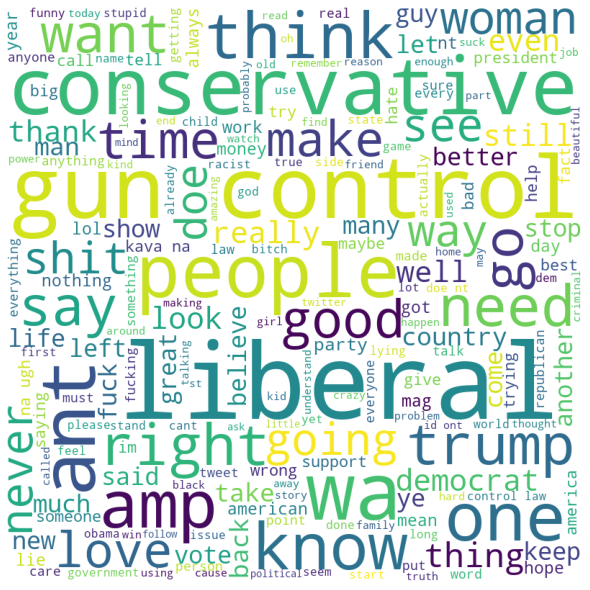

In [ ]:
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud4) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
plt.show() 

## Counting the occurence of particular words

In [ ]:
#Drop those that are not relevant to the tasking
train_df_c = train_df.dropna(subset=['subtask_c'])
train_df_c = train_df_c.drop(columns = ['subtask_a', 'subtask_b'])

In [ ]:
#Check count of categories 
train_df_c.groupby(['subtask_c']).count()

,id,tweet,clean_tweet,extra_clean_tweet,clean_tweet_str
subtask_c,,,,,
GRP,1074,1074,1074,1074,1074
IND,2407,2407,2407,2407,2407
OTH,395,395,395,395,395


In [ ]:
#Function to count a particular word in tuple 
def count_word(tup1, tup2, tup3, words):
  '''
  Takes in 3 tuples for the case of C and words which is a list of words
  you'd like to know the count of
  '''
  count_word_dict = {}
  for word in words:
    count_word_dict[word] = [tup1.count(word), tup2.count(word), tup3.count(word)]
    print('The count for', word, 'Ind:', tup1.count(word), 'Grp:', tup2.count(word), 'Oth:', tup3.count(word)) 
  return count_word_dict 

In [ ]:
tweet = train_df_c['tweet']
ind_filtered = list(sum((tweet)[train_df_c['subtask_c']=='IND'].map(tokenize), []))
grp_filtered = list(sum((tweet)[train_df_c['subtask_c'] == 'GRP'].map(tokenize), []))
oth_filtered = list(sum((tweet)[train_df_c['subtask_c'] == 'OTH'].map(tokenize), []))
ind_filtered_l = [x.lower() for x in ind_filtered]
grp_filtered_l = [x.lower() for x in grp_filtered]
oth_filtered_l = [x.lower() for x in oth_filtered]

In [ ]:
#Count Singular Words  
word_list = ['i', 'he', 'she', 'it', 'him', 'her', 'you']
sing = count_word(ind_filtered_l, grp_filtered_l, oth_filtered_l, word_list)

The count for i Ind: 584 Grp: 214 Oth: 71
The count for he Ind: 795 Grp: 113 Oth: 47
The count for she Ind: 610 Grp: 84 Oth: 23
The count for it Ind: 364 Grp: 194 Oth: 77
The count for him Ind: 131 Grp: 31 Oth: 20
The count for her Ind: 267 Grp: 45 Oth: 14
The count for you Ind: 1112 Grp: 344 Oth: 139


In [ ]:
#Count Plural Words  
word_list = ['we', 'they', 'us', 'them']
plu = count_word(ind_filtered_l, grp_filtered_l, oth_filtered_l, word_list)

The count for we Ind: 130 Grp: 125 Oth: 40
The count for they Ind: 194 Grp: 288 Oth: 73
The count for us Ind: 64 Grp: 51 Oth: 15
The count for them Ind: 81 Grp: 94 Oth: 17


In [ ]:
def plotter(dic, title):
  labels = []
  ind = []
  grp = []
  oth = []
  for k, v in dic.items(): 
    labels.append(k)
    ind.append(v[0])
    grp.append(v[1])
    oth.append(v[2])
  x = np.arange(len(labels)) #The label locations
  width = 0.30 #The width of the bars 

  fig, ax = plt.subplots(figsize=(8,8))
  rects1 = ax.bar(x-width, ind, width, label = 'IND')
  rects2 = ax.bar(x, grp, width, label = 'GRP')
  rects3 = ax.bar(x+width, oth, width, label = 'OTH')

  ax.set_ylabel('Counts')
  ax.set_title(title)
  ax.set_xticks(x)
  ax.set_xticklabels(labels)
  ax.legend()
  def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 3, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')
  autolabel(rects1)
  autolabel(rects2)
  autolabel(rects3)
  fig.tight_layout()
  return plt.show()


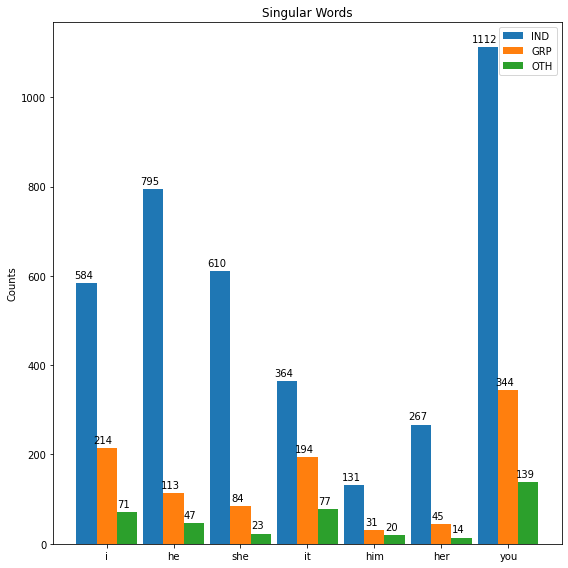

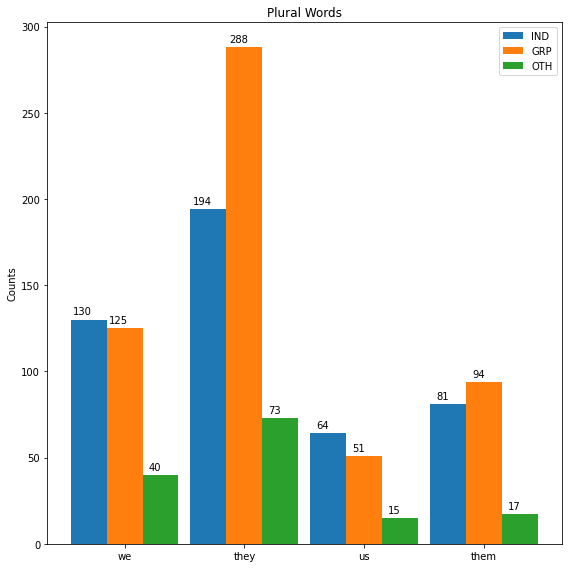

(None, None)

In [ ]:
plotter(sing, 'Singular Words'), plotter(plu,'Plural Words')

It is important to note that the ratio of the examples is approximately the following:
IND: 8 GRP: 3 OTH: 1

## TSNE

In [ ]:
from sklearn.manifold import TSNE
import pickle

In [ ]:
#import the embedding matrix and tokenizer
embedding_matrix = pd.read_csv('/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/glove_embed_a.csv')
len(embedding_matrix)

13828

In [ ]:
#import the necessary libraries 
Y = TSNE(n_components=2).fit_transform(embedding_matrix)


In [ ]:
with open('/content/drive/My Drive/CDS_Project/OLIDv1/Data/glove/NN/tokenizer_a.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)
word_index = tokenizer.word_index 

In [ ]:
len(word_index)

13828

In [ ]:
#Adjust the indexes such that the index reflects the word 
#Converting dataframe from dictionary
tsne_df = pd.DataFrame.from_dict(word_index, orient = 'index')
tsne_df = tsne_df.reset_index()
tsne_df = tsne_df.set_index([0])
tsne_df = tsne_df.rename(columns = {"index": "word"})

In [ ]:
#Merging the results from TSNE with word index
Y_df = pd.DataFrame(Y)
tsne_df[['dim1','dim2']] = Y_df[[0,1]]

2 Options
* Plot words from dataframe using a and b to slice it
* Plot a list of words of your choosing by amending word list

In [ ]:
#making the words the index
tsne_df_index = tsne_df.set_index(tsne_df['word'])
tsne_df_index = tsne_df_index.drop(columns ='word')
#Set a and b according to the data you want to visualise 
a = 1200
b = 1210
# tsne_df_index = tsne_df_index[a:b]
#Alternatively, plot a list of words that you would like
word_list = ['china', 'america', 'europe', 'australia']
tsne_df_index = tsne_df_index.loc[word_list]

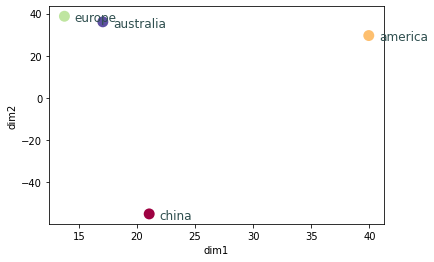

In [ ]:
from matplotlib import cm
fig, ax = plt.subplots()
cmap = cm.get_cmap('Spectral')
tsne_df_index.plot('dim1', 'dim2', kind='scatter', ax=ax, s=120, linewidth=0, 
        c=range(len(tsne_df_index)), colormap=cmap)

for k, v in tsne_df_index.iterrows():
    ax.annotate(k, v,
                xytext=(10,-5), textcoords='offset points',
                family='sans-serif', fontsize=12, color='darkslategrey')

In [ ]:
tsne_df_index

,dim1,dim2
word,,
china,21.048038,-55.117439
america,39.948765,29.589895
europe,13.751151,38.756687
australia,17.056992,36.108952


In [ ]:
tsne_df[tsne_df['word'] == 'sad'], tsne_df[tsne_df['word'] == 'angry']

(    word       dim1       dim2
 0                             
 343  sad  23.534185  24.005095,        word       dim1       dim2
 0                                
 1263  angry  40.582302 -25.061317)